## Imports

In [1]:
import os
import math
import glob
import cv2
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from moviepy.editor import VideoFileClip
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline

## Load Dataset

In [2]:
test_images = np.array([plt.imread(i) for i in glob.glob('./test_images/*.jpg')])

car_images = []
non_car_images = []

for root, dirs, files in os.walk('./dataset/vehicles/'):
    for file in files:
        if file.endswith('.png'):
            car_images.append(os.path.join(root, file))
            
for root, dirs, files in os.walk('./dataset/non-vehicles/'):
    for file in files:
        if file.endswith('.png'):
            non_car_images.append(os.path.join(root, file))

## Basic Summary of Dataset

In [3]:
n_car_images = len(car_images)
n_non_car_images = len(non_car_images)
img_shape = mpimg.imread(car_images[0]).shape
print('No. of car images: ', n_car_images)
print('No of non-car images: ', n_non_car_images)
print('Image shape: ', img_shape)

No. of car images:  9103
No of non-car images:  8968
Image shape:  (64, 64, 3)


### Car Image Examples

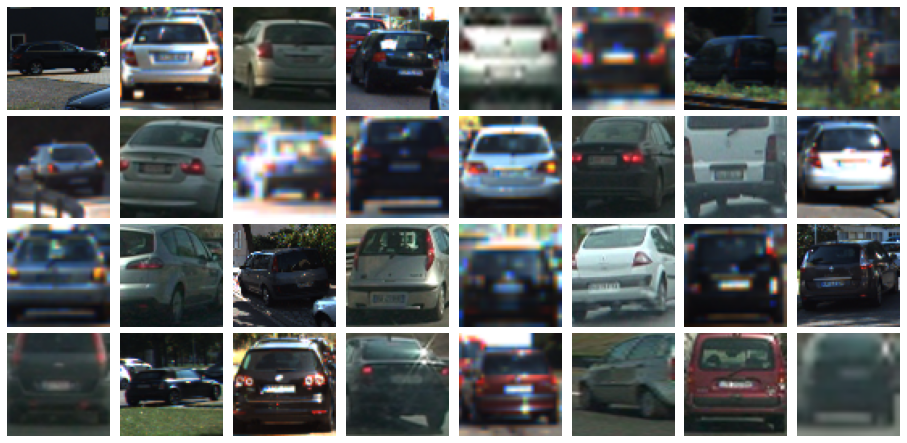

In [4]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = 0, wspace=.1)
axs = axs.ravel()

for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,n_car_images)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
plt.savefig('output_images/car_samples.png')

### Non-car Image Examples

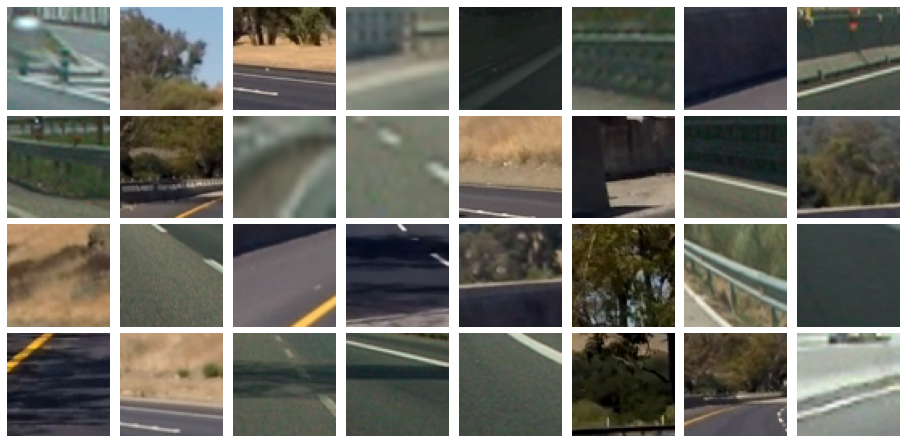

In [5]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = 0, wspace=.1)
axs = axs.ravel()

for i in np.arange(32):
    img = cv2.imread(non_car_images[np.random.randint(0,n_non_car_images)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
plt.savefig('output_images/non_car_samples.png')

## Feature Extraction Method

In [6]:
# Compute binned color features by scaling images down 
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector and flatten the vector in one row
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately,bins is the number of equally divided sectors in width
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
# Return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    #The orientations are the number of buckets we want to create. Since I want to have a 9 x 1 matrix, I will set the orientations to 9
    #pixels_per_cell defines the size of the cell for which we create the histograms.
    #cells_per_block which is the size of the block over which we normalize the histogram. Here, we mention the cells per blocks and not the number of pixels. 
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

# Extract feature wrapper that extracts and combines all features
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB' 
            
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)   

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        
    # Return list of feature vectors
    return features

## HOG Visualisation

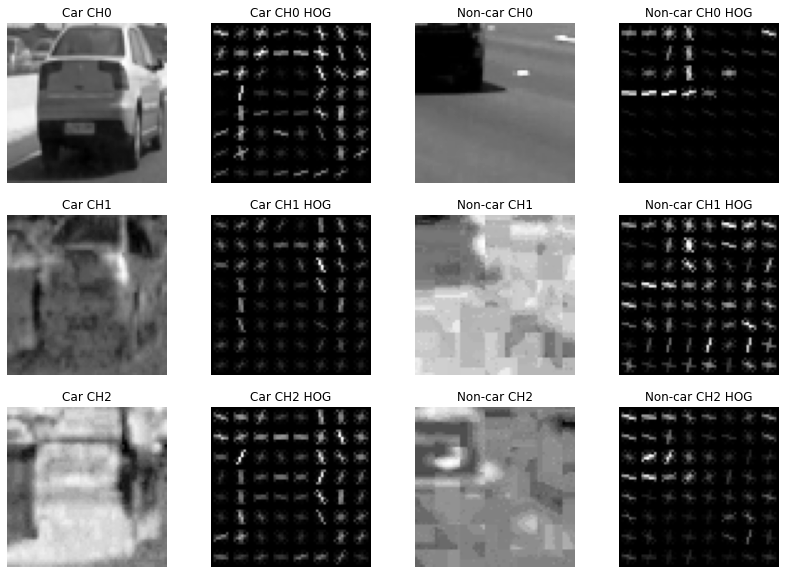

In [7]:
car_test = mpimg.imread(car_images[35])
car_test = cv2.cvtColor(car_test, cv2.COLOR_RGB2YCrCb)
non_car_test = mpimg.imread(non_car_images[20])
non_car_test = cv2.cvtColor(non_car_test, cv2.COLOR_RGB2YCrCb)

imgs = []
titles = []
for i in range(3):
    for feature_image, img_type in zip([car_test, non_car_test], ['Car', 'Non-car']):
        channel = feature_image[:,:,i]
        imgs.append(channel)
        titles.append(img_type + ' CH%d' % i)
        features, hog_image = get_hog_features(channel, orient=12, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)
        imgs.append(hog_image)
        titles.append(img_type + ' CH%d' % i + ' HOG')
        
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(14, 10))
axes = axes.ravel()
for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.savefig('output_images/HOG_comparison.png')

# Feature Extraction

In [8]:
### Parameters
spatial = 32
hist_bins = 32
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size= (32, 32)
heat_threshold= 4 # 12
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" #ALL,0 best
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (500, 710, 2.5)]
#Get a list at which each single element contains the features of the image
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))


non_car_features = extract_features(non_car_images,cspace=colorspace,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))

# Data Preparation

In [9]:
# Preserve State to compare parameter tuning 
#Random int
rand_state = np.random.randint(0, 100)

# Create an array stack of feature vectors with rows equals to #of images and cols equal to # features
X = np.vstack((car_features, non_car_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X scale feature values for better performance
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Split up data into randomized training and test sets,random_state is used to shuffle data before splitting
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 8460


## Classifier

In [10]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

21.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9895
My SVC predicts:      [0. 1. 1. 1. 0. 0. 1. 1. 1. 0.]
For these 10 labels:  [0. 1. 1. 1. 0. 0. 1. 1. 1. 0.]
0.00299 Seconds to predict 10 labels with SVC


## Data Saving to Pickle

In [11]:
# Save data to pickle file
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial"] = spatial
dist_pickle["hist_bins"] = hist_bins
pickle.dump(dist_pickle, open("svc_pickle.p", 'wb') )

print('Classifier parameters saved to file!')

Classifier parameters saved to file!


## Data Loading from Pickle

In [12]:
print('Loading Classifier parameters...')
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatia = dist_pickle["spatial"]
hist_bins = dist_pickle["hist_bins"]

print('Loading is done!')

Loading Classifier parameters...
Loading is done!
